In [151]:
import json
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib import cm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [152]:
infile = open('FEM_converted.json', 'r')

In [153]:
var_dict = json.load(infile)

In [154]:
infile.close()

In [155]:
nnode = var_dict["nnode"]
xcoord = np.asarray([i[0] for i in var_dict["coord"]])
ycoord = np.asarray([i[1] for i in var_dict["coord"]])
nelem = var_dict["nelem"]
connect = var_dict["connect"]
nfix = var_dict["nfix"]
fixnodes = var_dict["fixnodes"]
ndload = var_dict["ndload"]
dloads = var_dict["dloads"]

In [156]:
def create_Dmat(nu, E):
    return E/((1+nu)*(1-2*nu)) * np.asarray([[1-nu,nu,0],[nu,1-nu,0],[0,0,(1-2*nu)/2]])

In [157]:
def elresid(xa, ya, xb, yb, tx, ty):
    length = np.sqrt((xa-xb)*(xa-xb)+(ya-yb)*(ya-yb))
    return np.asarray([tx,ty,tx,ty])*length/2

In [158]:
def elstif(xa,ya,xb,yb,xc,yc,Dmat):
    # Define B matrix
    nax = -(yc-yb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nay =  (xc-xb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nbx = -(ya-yc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    nby =  (xa-xc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    ncx = -(yb-ya)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    ncy =  (xb-xa)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    area = (1/2)*np.abs( (xb-xa)*(yc-ya) - (xc-xa)*(yb-ya) )
    Bmat = np.asarray([[nax, 0, nbx, 0, ncx, 0],
                        [0, nay, 0, nby, 0, ncy],
                        [nay, nax, nby, nbx, ncy, ncx]])
    
    # Return element stiffness
    return area*np.dot(np.dot(np.transpose(Bmat), Dmat), Bmat)

In [159]:
class steelAlNet(nn.Module):
    def __init__(self, var_dict):
        super(steelAlNet, self).__init__()
        torch.manual_seed(12)
        self.nnode = var_dict["nnode"]
        self.xcoord = np.asarray([i[0] for i in var_dict["coord"]])
        self.ycoord = np.asarray([i[1] for i in var_dict["coord"]])
        self.nelem = var_dict["nelem"]
        self.connect = var_dict["connect"]
        self.nfix = var_dict["nfix"]
        self.fixnodes = var_dict["fixnodes"]
        self.ndload = var_dict["ndload"]
        self.dloads = var_dict["dloads"]
        self.elem_material = nn.Parameter(torch.rand(self.nelem), requires_grad=True)

    def forward(self):
        # Young's Modulus and Poisson's Ratio for Steel
        E_st = 200
        nu_st = 0.3
        # For Aluminum
        E_al = 69
        nu_al = 0.33
        
        elem_weight = [0] * self.nelem

        # Define what each element is made of (steel or aluminum)
        for lmn in range(self.nelem):
            with torch.no_grad():
                # > 0.5 == aluminum
                if self.elem_material[lmn].item() > 0.5:
                    elem_weight[lmn] = 0.0027
                else:
                    elem_weight[lmn] = 0.00783

        # Steel D-matrix
        Dmat_st = create_Dmat(nu_st, E_st)
        # Aluminum D-matrix
        Dmat_al = create_Dmat(nu_al, E_al)

        Stif = np.zeros((2*self.nnode, 2*self.nnode))

        for lmn in range(self.nelem):
            a = connect[lmn][0]
            b = connect[lmn][1]
            c = connect[lmn][2]
            
            if self.elem_material[lmn] > 0.5:
                k = elstif(self.xcoord[a], self.ycoord[a],
                            self.xcoord[b], self.ycoord[b],
                            self.xcoord[c], self.ycoord[c], Dmat_al)
            else:
                k = elstif(self.xcoord[a], self.ycoord[a],
                            self.xcoord[b], self.ycoord[b],
                            self.xcoord[c], self.ycoord[c], Dmat_st)


            for i in range(3):
                for ii in range(2):
                    for j in range(3):
                        for jj in range(2):
                            rw = 2*(self.connect[lmn][i])+ii
                            cl = 2*(self.connect[lmn][j])+jj
                            Stif[rw][cl] = Stif[rw][cl] + k[2*i+ii][2*j+jj]
            
        resid = np.zeros(2*self.nnode)

        pointer = [1, 2, 0]
        for i in range(self.ndload):
            lmn = self.dloads[i][0]
            face = self.dloads[i][1]
            a = connect[lmn][face]
            b = connect[lmn][pointer[face]]
            r = elresid(self.xcoord[a], self.ycoord[a],
                        self.xcoord[b], self.ycoord[b],
                        self.dloads[i][2], self.dloads[i][3])
            
            resid[2*a]=resid[2*a]+r[0]
            resid[2*a+1]=resid[2*a+1]+r[1]
            resid[2*b]=resid[2*b]+r[2]
            resid[2*b+1]=resid[2*b+1]+r[3]

        for i in range(self.nfix):
            rw=2*(self.fixnodes[i][0]) + self.fixnodes[i][1]
            for j in range(2*self.nnode):
                Stif[rw][j] = 0
            Stif[rw][rw] = 1.0
            resid[rw] = self.fixnodes[i][2]

        V, D = np.linalg.eig(Stif)
        eigenvecs = np.transpose(V)
        eigenvals = D
        u = np.linalg.solve(Stif, resid)

        uxcoord = [0] * nnode
        uycoord = [0] * nnode
        for i in range(self.nnode):
            with torch.no_grad():
                uxcoord[i] = self.xcoord[i] + u[2*i]
                uycoord[i] = self.ycoord[i] + u[2*i+1]

        return self.elem_material, elem_weight, uxcoord, uycoord

tensor(0.4657, grad_fn=<SelectBackward0>)
tensor(0.4691, grad_fn=<SelectBackward0>)
tensor(0.4726, grad_fn=<SelectBackward0>)


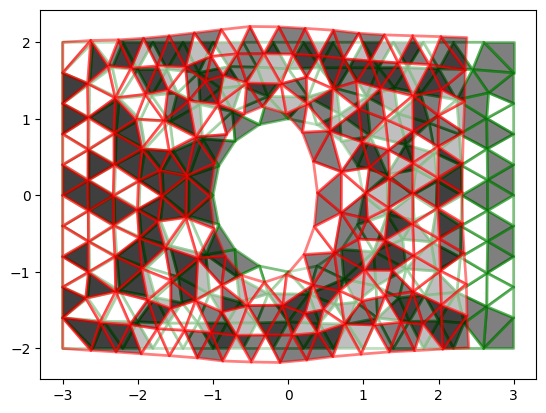

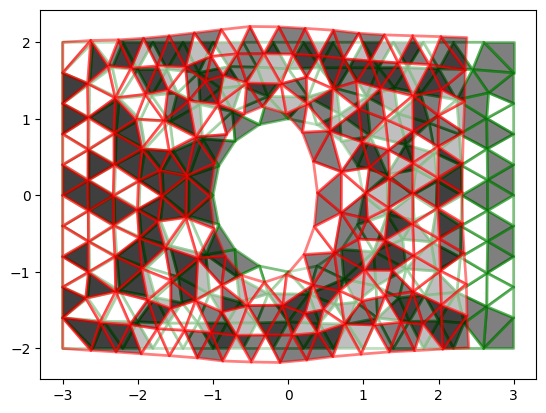

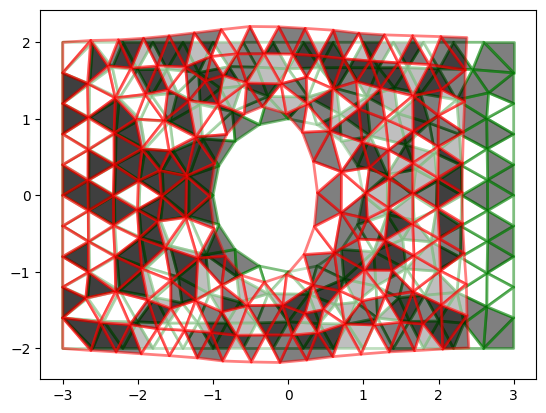

In [160]:
net = steelAlNet(var_dict)

num_epochs = 3
learning_rate = 100
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

ideal_weights = [0.0027] * nelem

for epoch in range(num_epochs):
    optimizer.zero_grad()
    elem_material, elem_weight, uxcoord, uycoord = net()
    print(elem_material[0])

    facecolors = [0] * nelem

    for lmn in range(nelem):
        if elem_material[lmn] > 0.5:
            facecolors[lmn] = 1
        else:
            facecolors[lmn] = 0
    
    
    
    fig, ax = plt.subplots()
    triang = mtri.Triangulation(xcoord, ycoord, connect)
    triang2 = mtri.Triangulation(uxcoord, uycoord, connect)
    plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='green', linewidth=2, cmap='Greys', alpha=0.5)
    plt.tripcolor(triang2, ax, facecolors=facecolors, edgecolors='r', linewidth=2, cmap='Greys', alpha=0.5)

    x_loss = loss_fn(torch.tensor(uxcoord, requires_grad=True), torch.tensor(xcoord)) * 100
    y_loss = loss_fn(torch.tensor(uycoord, requires_grad=True), torch.tensor(ycoord)) * 100
    weight_difference = [elem_material[i] + (elem_weight[i] - ideal_weights[i]) for i in range(nelem)]
    loss = loss_fn(elem_material, torch.tensor(weight_difference))
    loss = loss - x_loss - y_loss
    loss.backward()
    optimizer.step()

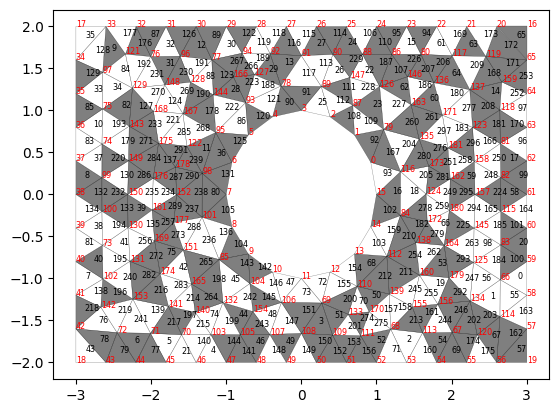

In [161]:
fig, ax = plt.subplots()
triang = mtri.Triangulation(xcoord, ycoord, connect)
plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='k', cmap='Greys', alpha=0.5)
for i in range(nnode):
    plt.text(xcoord[i], ycoord[i], i, color='r', size='xx-small')
for i in range(nelem):
    n1, n2, n3 = connect[i]
    avgx = (xcoord[n1] + xcoord[n2] + xcoord[n3]) / 3
    avgy = (ycoord[n1] + ycoord[n2] + ycoord[n3]) / 3
    plt.text(avgx, avgy, i, size='xx-small')

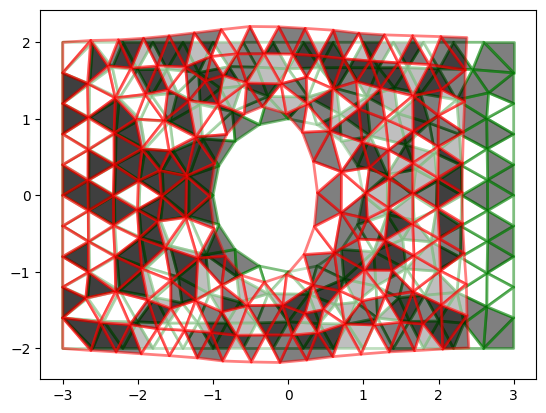

In [162]:
triang2 = mtri.Triangulation(uxcoord, uycoord, connect)
plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='green', linewidth=2, cmap='Greys', alpha=0.5)
plt.tripcolor(triang2, ax, facecolors=facecolors, edgecolors='r', linewidth=2, cmap='Greys', alpha=0.5)